# NEURAL NETWORK OBJECT RECOGNITION

## PROJECT

UoEO Machine Learning

Assignment Due Date: 20 January, 2025

## AUTHOR

Maria Ingold

## PROJECT DESCRIPTION

Your ML model should address following points:
1. Introduction: Introduce CIFAR-10 and perform basic Exploratory Data Analysis (EDA)
2. Partition and Validation: Method to partition the validation set from the training data, insights into metadata, importance of separate validation.
3. Artificial Neural Network Architecture: Elaborate.
4. Activation Function: What and why selected.
5. Loss Function: Describe what and why implemented.
6. Epochs, Batch Size, Learning Rate: Number and why.
7. Evalution: Insights on Neural Network design elements strategy.
8. Conclusion: Reflections on learnings acquired.


## IMPORT LIBRARIES

In [1]:
import numpy as np                                   # numerical computation
import matplotlib.pyplot as plt                      # plots
import tensorflow as tf                              # machine learning
from tensorflow.keras.datasets import cifar10        # CIFAR-10 dataset
from sklearn.model_selection import train_test_split # train test split
from tensorflow.keras.utils import to_categorical    # one-hot encoding
from tensorflow.keras.models import Sequential       # neural network linear layer stack
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # CNN layers
from tensorflow.keras.optimizers import Adam         # optimiser
from tensorflow.keras.preprocessing.image import ImageDataGenerator # data augmentation
from tensorflow.keras.callbacks import EarlyStopping # early stopping

## LOAD DATASET

CIFAR-10 (Krizhevsky, 2009)
- 60,000 32x32 colour images
- 10 classes, 6000 images per class
- 50,000 training
- 10,000 testing



In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


## EXPLORATORY DATA ANALYSIS (EDA)

### Shape

- Training data shape: 50,000 images of 32x32 size x 3 (RGB = Red Green Blue)
- Training labels: 50,000 labels of just one name
- Training data shape: 10,000 images of 32x32 size x 3 (RGB = Red Green Blue)
- Testing lables shape: 10,000 labels of just one name

In [3]:
# Inspect the shape of the data
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Testing data shape: (10000, 32, 32, 3)
Testing labels shape: (10000, 1)


### Class / Label Names
- Class names as mapped by CIFAR-10
- 10 classes map to the following:
- 0 = airplane
- 1 = automobile
- 2 = bird
- 3 = cat
- 4 = deer
- 5 = dog
- 6 = frog
- 7 = horse
- 8 = ship
- 9 = truck


In [4]:
LABEL_NAMES = ['airplane', 'automobile','bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Visualise

- Ten random images per label name

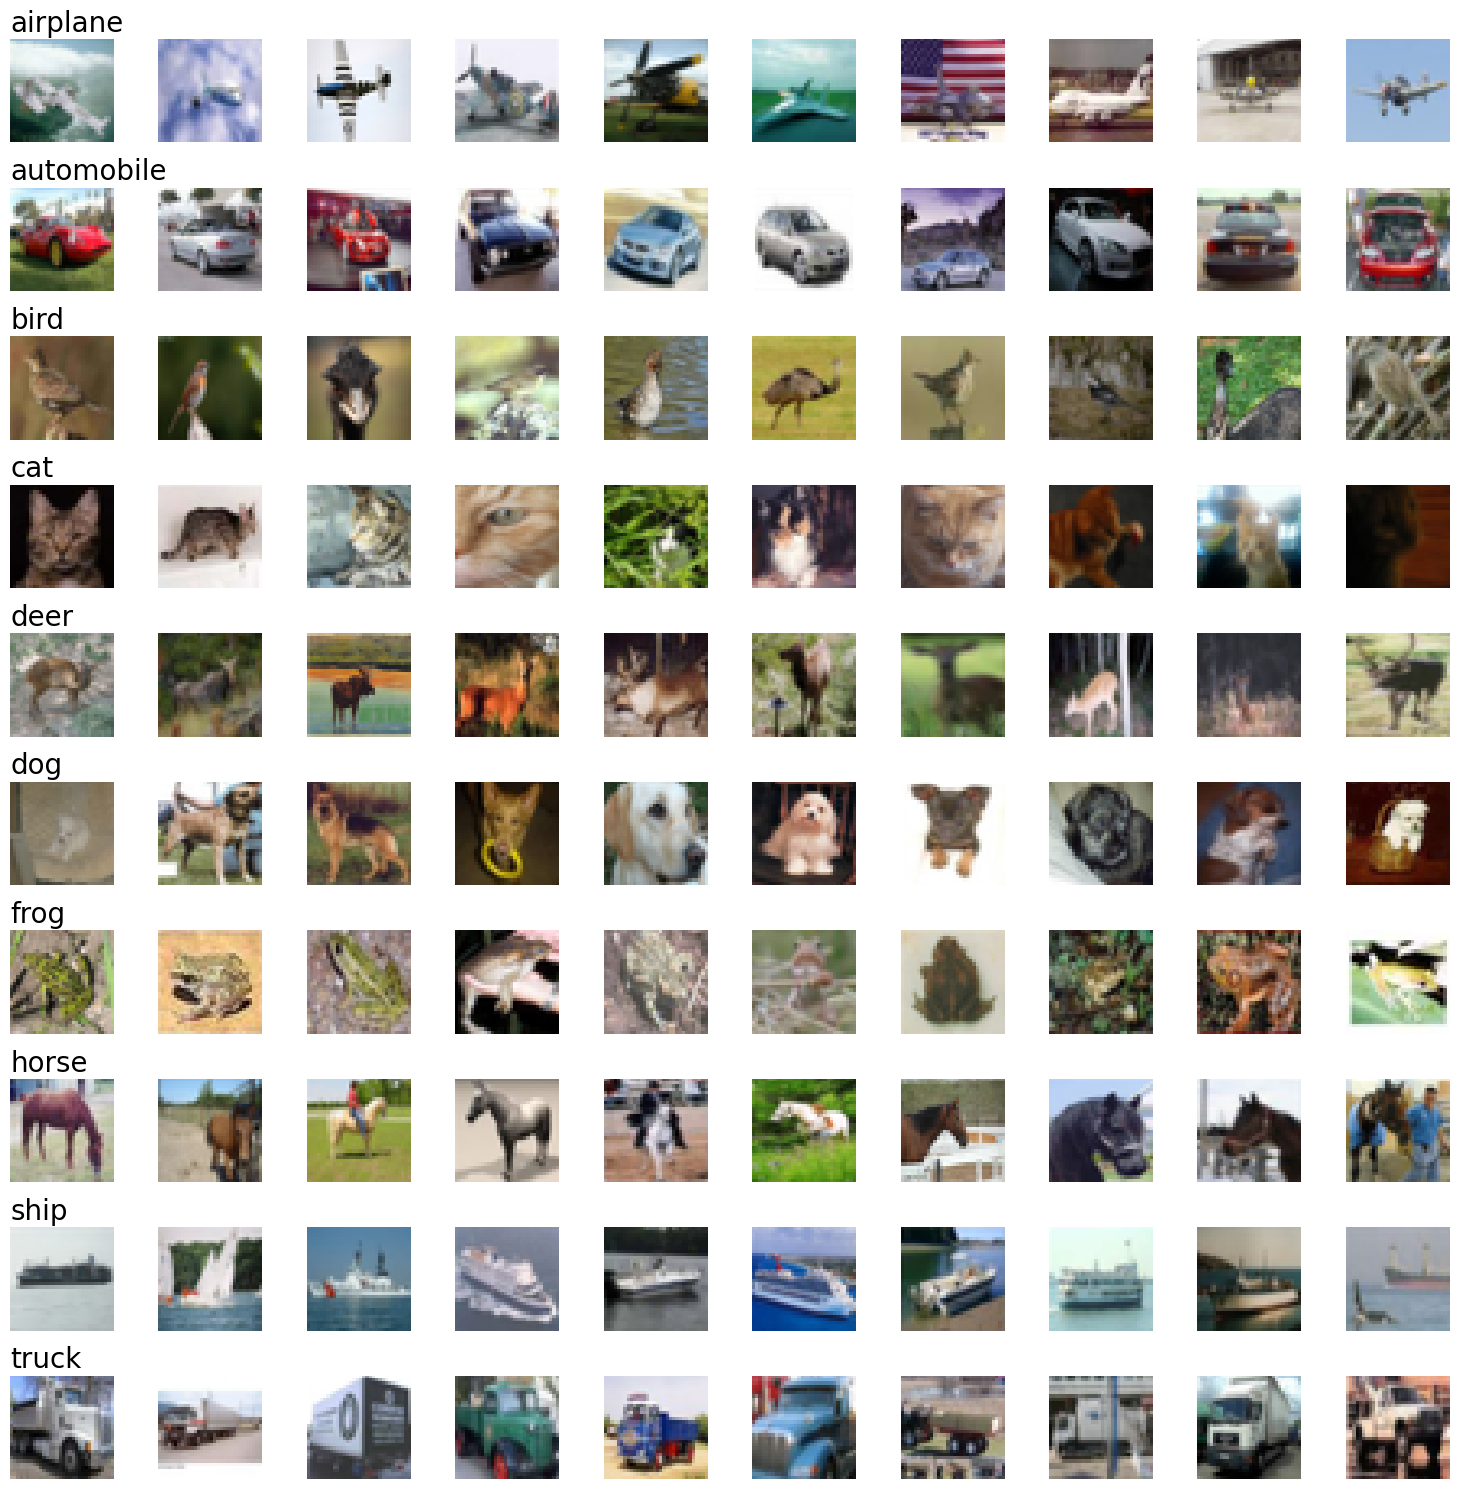

In [5]:
# Number of samples to display per class
num_samples = 10

# Create a figure
fig, axes = plt.subplots(len(LABEL_NAMES), num_samples, figsize=(15, 15))

# Iterate over each class
for class_idx, class_name in enumerate(LABEL_NAMES):
    # Find the indices of images belonging to the current class
    class_indices = np.where(y_train.flatten() == class_idx)[0]

    # Randomly select `num_samples` images from the class
    selected_indices = np.random.choice(class_indices, num_samples, replace=False)

    # Plot the images
    for i, img_idx in enumerate(selected_indices):
        ax = axes[class_idx, i]
        ax.imshow(x_train[img_idx])
        ax.axis("off")
        if i == 0:  # Add class name only on the first image
            ax.set_title(class_name, fontsize=20, loc="left")

# Adjust layout and display
plt.tight_layout()
plt.show()

## PARTITION TRAINING INTO VALIDATION
Dataset comes with
- training set (50,000)
- test set (10,000)

Now split training set into:
- training set
- validation set

Rationale:
- *** Research here as to correct size.
- 10%, 20%?????

Result:
- training set (40,000)
- validation set (10,000)
- test set (10,000)

In [6]:
# Split the training data into training and validation sets
x_train, x_validate, y_train, y_validate = train_test_split(
    x_train, y_train, test_size=0.2, random_state=0)

# Check the new shapes
print(f"New training data shape: {x_train.shape}")
print(f"Validation data shape: {x_validate.shape}")
print(f"New training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_validate.shape}")

New training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
New training labels shape: (40000, 1)
Validation labels shape: (10000, 1)


## PRE-PROCESSING

- Preprocess after partitioning to not influence the test set.
- Normalise
- One-hot encode class labels

### Normalise

- RGB channel pixel value intensities range from 0 to 255
- 0 = black
- 255 (original) or 1 (normalised) = full intensity
- Red (R) channel = 0
- Green (G) channel = 1
- Blue (B) channel = 2
- Normalising helps Neural Network

#### Understand the data

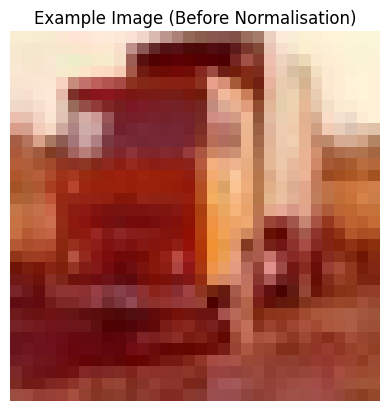

Pixel values (partial):
[[248 248 247 246 252]
 [247 245 245 246 248]
 [248 245 246 248 241]
 [250 248 247 248 246]
 [248 248 251 251 245]]


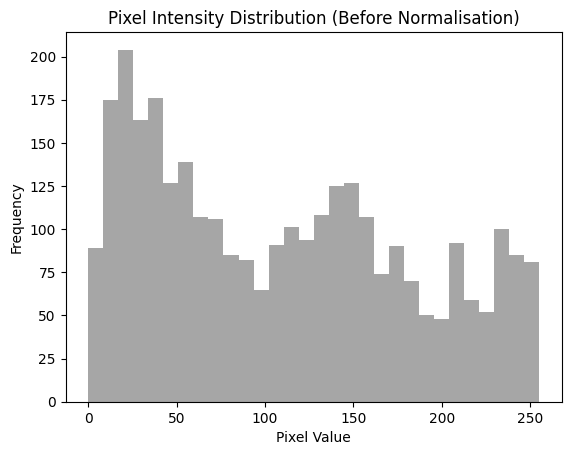

In [7]:
# Choose an example image from the training set
example_image = x_train[100]

# Display the image
plt.imshow(example_image)
plt.title("Example Image (Before Normalisation)")
plt.axis("off")
plt.show()

# Print pixel values for first five rows and columns of image
print("Pixel values (partial):")
print(example_image[:5, :5, 0])  # First channel (R)

# Visualise pixel intensity distribution
plt.hist(example_image.flatten(), bins=30, color='grey', alpha=0.7)
plt.title("Pixel Intensity Distribution (Before Normalisation)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [8]:
# Display the original range of pixel values
print("Original pixel range (train):", np.min(x_train), "to", np.max(x_train))
print("Original pixel range (validate):", np.min(x_validate), "to", np.max(x_validate))
print("Original pixel range (test):", np.min(x_test), "to", np.max(x_test))

Original pixel range (train): 0 to 255
Original pixel range (validate): 0 to 255
Original pixel range (test): 0 to 255


#### Normalise RGB from [0, 255] to [0, 1]

In [9]:
# Normalize the image data to the range [0, 1]
x_train = x_train.astype('float32') / 255.0
x_validate = x_validate.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Display the new range of pixel values
print("Normalized pixel range (train):", np.min(x_train), "to", np.max(x_train))
print("Normalized pixel range (validate):", np.min(x_validate), "to", np.max(x_validate))
print("Normalized pixel range (test):", np.min(x_test), "to", np.max(x_test))

Normalized pixel range (train): 0.0 to 1.0
Normalized pixel range (validate): 0.0 to 1.0
Normalized pixel range (test): 0.0 to 1.0


#### Understand the normalisation change

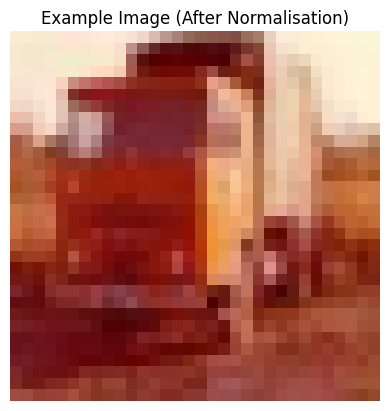

Pixel values (partial):
[[0.972549   0.972549   0.96862745 0.9647059  0.9882353 ]
 [0.96862745 0.9607843  0.9607843  0.9647059  0.972549  ]
 [0.972549   0.9607843  0.9647059  0.972549   0.94509804]
 [0.98039216 0.972549   0.96862745 0.972549   0.9647059 ]
 [0.972549   0.972549   0.9843137  0.9843137  0.9607843 ]]


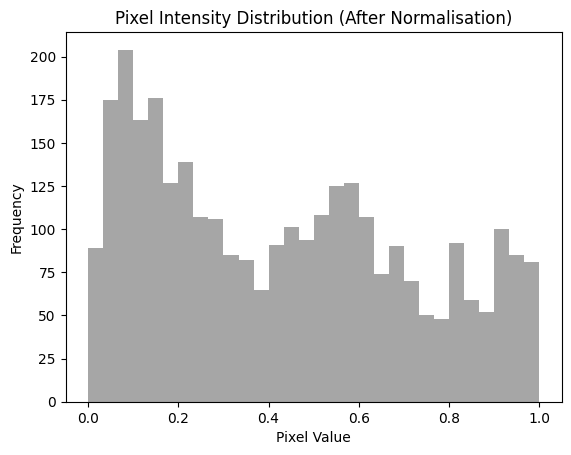

In [10]:
# Choose an example image from the training set
normalised_example_image = x_train[100]

# Display the image
plt.imshow(example_image)
plt.title("Example Image (After Normalisation)")
plt.axis("off")
plt.show()

# Print pixel values for the first few rows of the image
print("Pixel values (partial):")
print(normalised_example_image[:5, :5, 0])  # First channel (R)

# Visualise pixel intensity distribution
plt.hist(normalised_example_image.flatten(), bins=30, color='grey', alpha=0.7)
plt.title("Pixel Intensity Distribution (After Normalisation)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

### One-hot encode
- [9] is truck
- [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] is one-hot encoding of [9] and still means truck

In [11]:
# Show an example label before one-hot encoding
print("Label before one-hot encoding:", y_train[100])

# Convert class labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=10)
y_validate = to_categorical(y_validate, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("Label after one-hot encoding:", y_train[100])

Label before one-hot encoding: [9]
Label after one-hot encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


### Shape

- Data is still the same shape
- Labels are now 10, not 1

In [12]:
# Check the shapes of the preprocessed data
print(f"Training data shape: {x_train.shape}")
print(f"Validation data shape: {x_validate.shape}")
print(f"Testing data shape: {x_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_validate.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (40000, 32, 32, 3)
Validation data shape: (10000, 32, 32, 3)
Testing data shape: (10000, 32, 32, 3)
Training labels shape: (40000, 10)
Validation labels shape: (10000, 10)
Testing labels shape: (10000, 10)


## MODEL 1

Adjustments: None, baseline.

Architecture
- Number layers: 3
- Convolutional filters (kernels): 32, 64, 128
- Convolutional filter (kernel) size: 3x3
- Pool size: 2x2
- Dropout rate: 50%
- Dense: 128, 64
- Activation function: ReLU

Compile
- Optimiser: Adam
- Learning rate: .001
- Loss function: categorical crossentropy
- Metric: accuracy

Training settings:
- Epochs: 20
- Batch size: 64

Performance on validation set:
- Accuracy (Training): 0.8469
- Accuracy (Validation): 0.7164
- Loss (Training): 0.4274
- Loss (Validation): 0.985

Visualisation: Model Accuracy
- Epoch 10 Validation plateaus

Visualisation: Model Loss
- Epoch 10 Validation increases (bad)

Summary
- Stops generalising at epoch 10
- Further epochs not useful
- Overfitting



### Neural Network Architecture

In [18]:
# Initialize the model
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

# Flatten the feature maps into a 1D vector
model.add(Flatten())

# Add fully connected (dense) layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Randomly drop 50% neurons to prevent overfitting
model.add(Dense(64, activation='relu'))

# Classifier: Output layer with 10 classes
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,426 (1.39 MB)

 Trainable params: 364,426 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model


In [20]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001), # Adaptive learning rate optimizer
    loss='categorical_crossentropy',     # Loss function for multi-class classification
    metrics=['accuracy']                 # Metric to track during training
)

### Train and Validate


In [21]:
# Train the model
history = model.fit(
    x_train, y_train,                         # Training data and labels
    validation_data=(x_validate, y_validate), # Validation data and labels
    epochs=20,                                # Number of epochs (you can adjust this)
    batch_size=64,                            # Number of samples per batch
    verbose=1                                 # Print training progress
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 124ms/step - accuracy: 0.2463 - loss: 1.9879 - val_accuracy: 0.4649 - val_loss: 1.4592
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 116ms/step - accuracy: 0.4667 - loss: 1.4653 - val_accuracy: 0.5547 - val_loss: 1.2284
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 121ms/step - accuracy: 0.5496 - loss: 1.2638 - val_accuracy: 0.6000 - val_loss: 1.1257
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 74s 118ms/step - accuracy: 0.5890 - loss: 1.1530 - val_accuracy: 0.6375 - val_loss: 1.0295
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 124ms/step - accuracy: 0.6378 - loss: 1.0338 - val_accuracy: 0.6643 - val_loss: 0.9564
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 120ms/step - accuracy: 0.6622 - loss: 0.9598 - val_accuracy: 0.6781 - val_loss: 0.9266
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 115ms/step - accuracy: 0.6937 - loss: 0.8763 - val_accuracy: 0.6885 - val_loss: 0.8951
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 73s 117ms/step - accuracy: 0.7080 - loss: 0

### Visualise

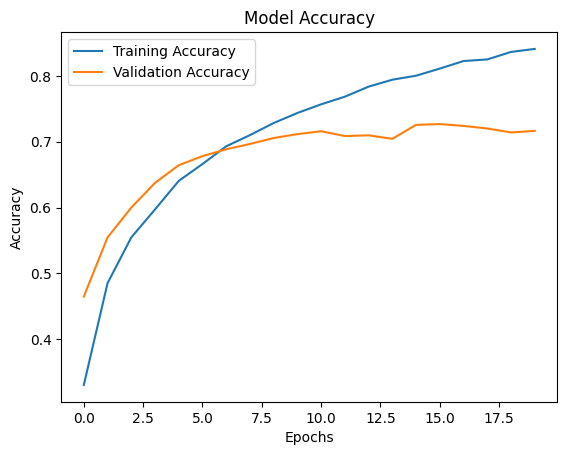

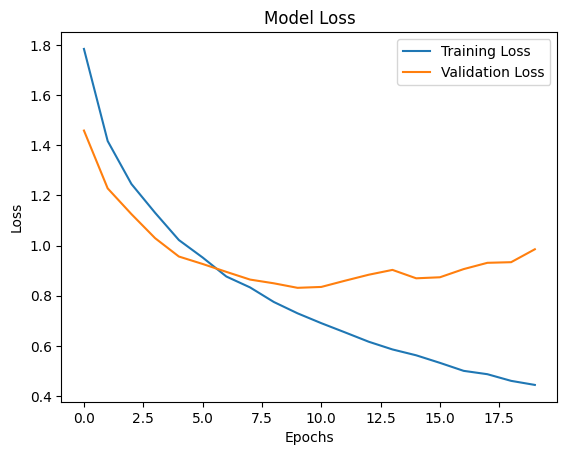

In [22]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## MODEL 2

Adjustments to avoid overfitting:
- Data augmentation to artificially increase diversity of training data
- Early stopping when loss stops improving

Architecture (unchanged)
- Number layers: 3
- Convolutional filters (kernels): 32, 64, 128
- Convolutional filter (kernel) size: 3x3
- Pool size: 2x2
- Dropout rate: 50%
- Dense: 128, 64
- Activation function: ReLU

Compile (unchanged)
- Optimiser: Adam
- Learning rate: .001
- Loss function: categorical crossentropy
- Metric: accuracy

Training settings
- Epochs: 20 (with early stopping)
- Did not stop early. Reached 20.
- Batch size: 64

Performance on validation set:
- Accuracy (Training): 0.6930
- Accuracy (Validation): 0.7433
- Loss (Training): 0.8781
- Loss (Validation): 0.7431

Visualisation: Model Accuracy
- Training lower due to augmentation complexity (expected)
- Validation consistently higher (good)

Visualisation: Model Loss
- Training higher due to augmentation complexity (expected)
- Validation consistently lower (good)

Summary
- No divergence between train and validate
- Overfitting mitigated
- Model learned features
- Improved generalisation

Comparison: Validation accuracy
- Old: 0.7164
- New: 0.7433
- % improvement: +3.75% (good)

Comparison: Validation loss
- Old: 0.9854
- New: 0.7431
- % improvement: -24.59% (great)


### Neural Network Architecture

In [13]:
# Initialize the model
model = Sequential()

# Add convolutional and pooling layers
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))

# Flatten the feature maps into a 1D vector
model.add(Flatten())

# Add fully connected (dense) layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Randomly drop 50% neurons to prevent overfitting
model.add(Dense(64, activation='relu'))

# Classifier: Output layer with 10 classes
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 364,426 (1.39 MB)

 Trainable params: 364,426 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

### Compile the Model

In [14]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001), # Adaptive learning rate optimizer
    loss='categorical_crossentropy',     # Loss function for multi-class classification
    metrics=['accuracy']                 # Metric to track during training
)

### Data Augmentation

In [15]:
# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,       # Random rotation up to 15 degrees
    width_shift_range=0.1,   # Random horizontal shifts (10% of image width)
    height_shift_range=0.1,  # Random vertical shifts (10% of image height)
    horizontal_flip=True     # Random horizontal flips
)

# Fit the augmentation generator to the training data (x_train is untouched)
datagen.fit(x_train)

### Early Stopping

In [16]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs of no improvement
    restore_best_weights=True # Revert to the best weights
)

### Train and Validate

In [17]:
# Train the model with data augmentation and early stopping
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64), # Use augmented data
    validation_data=(x_validate, y_validate),      # Validation data remains unaugmented
    epochs=20,
    callbacks=[early_stopping],                    # Apply early stopping
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.2206 - loss: 2.0263 - val_accuracy: 0.4504 - val_loss: 1.4807
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 43ms/step - accuracy: 0.4233 - loss: 1.5692 - val_accuracy: 0.5338 - val_loss: 1.2913
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.4841 - loss: 1.4227 - val_accuracy: 0.5623 - val_loss: 1.2065
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 47ms/step - accuracy: 0.5226 - loss: 1.3257 - val_accuracy: 0.6040 - val_loss: 1.1140
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.5578 - loss: 1.2460 - val_accuracy: 0.6234 - val_loss: 1.0569
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.5770 - loss: 1.2000 - val_accuracy: 0.6128 - val_loss: 1.0986
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.5927 - loss: 1.1498 - val_accuracy: 0.6471 - val_loss: 1.0163
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.6076 - loss: 1.1137 - val_accurac

### Visualise

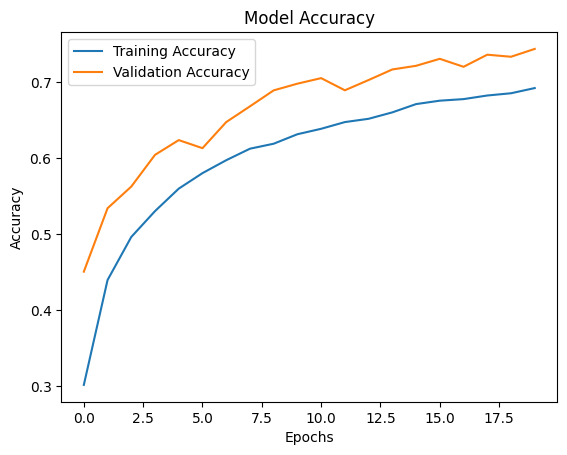

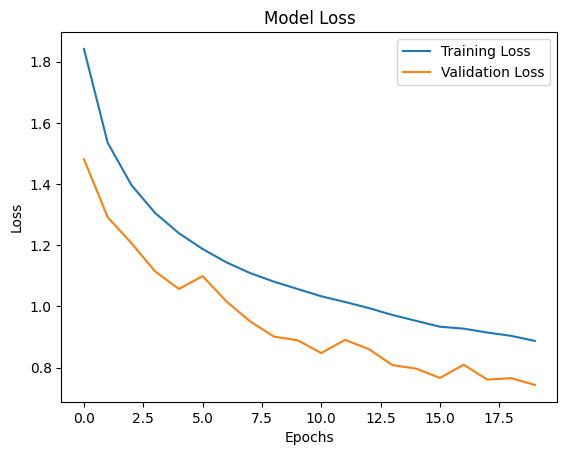

In [18]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()